In [6]:
from tensorflow.python.keras import backend as K
K._get_available_gpus()

['/device:GPU:0']

In [1]:
import tensorflow as tf
import cv2 
import numpy as np
import pandas as pd
import keras.models as models
import matplotlib.pyplot as plt 
from keras.models import Model
from keras import backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, Reshape, Bidirectional, LSTM, Dense, Lambda, Activation, BatchNormalization, Dropout
from keras.optimizers import Adam


In [2]:
img_dir = "../dataset/"
train_loc = "train_v2/train/"
test_loc = "test_v2/test/"

In [3]:
train = pd.read_csv('../dataset/written_name_train_v2.csv')
test = pd.read_csv('../dataset/written_name_test_v2.csv')

In [4]:
type(test)

pandas.core.frame.DataFrame

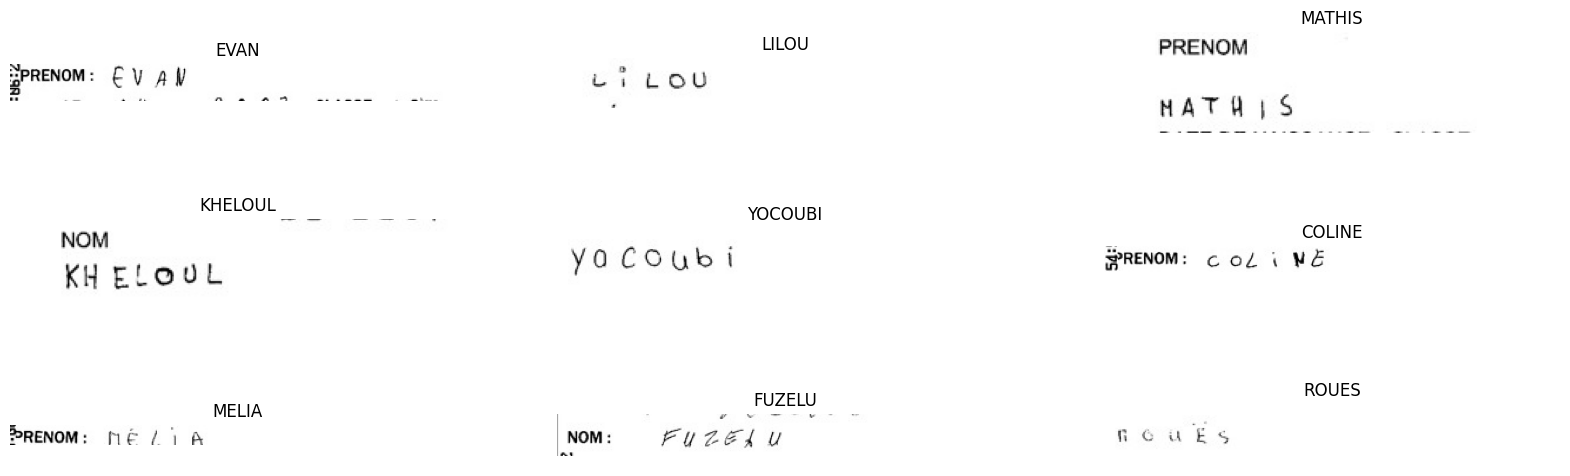

In [5]:
plt.figure(figsize=(20,30))

for i in range(9):
    plt.subplot(3,3, i+1)
    img_loc = img_dir+train_loc+train.loc[i+200,'FILENAME']
    image = cv2.imread(img_loc, cv2.IMREAD_COLOR)
    plt.imshow(image)
    plt.title(train.loc[i+200,'IDENTITY'],fontsize= 12)    
    # print(img_dir)
    plt.axis('off')
plt.subplots_adjust(wspace=0.2 , hspace=-0.91)


Cleaning the data

In [6]:
print("Number of NaNs in train set:" ,train["IDENTITY"].isnull().sum())
print("Number of NaNs in train set:" ,test["IDENTITY"].isnull().sum())

Number of NaNs in train set: 565
Number of NaNs in train set: 70


In [7]:
train.dropna(axis=0 , inplace=True)
test.dropna(axis=0 , inplace=True)

In [8]:
print("Number of NaNs in train set:" ,train["IDENTITY"].isnull().sum())
print("Number of NaNs in train set:" ,test["IDENTITY"].isnull().sum())

Number of NaNs in train set: 0
Number of NaNs in train set: 0


Cleaning the data with the label 'UNREADABLE'

In [9]:
unreadable = train[train["IDENTITY"] == 'UNREADABLE']
unreadable.reset_index(inplace=True , drop=True)
unreadable

,FILENAME,IDENTITY
0,TRAIN_00807.jpg,UNREADABLE
1,TRAIN_01220.jpg,UNREADABLE
2,TRAIN_02240.jpg,UNREADABLE
3,TRAIN_02861.jpg,UNREADABLE
4,TRAIN_08931.jpg,UNREADABLE
...,...,...
97,TRAIN_307024.jpg,UNREADABLE
98,TRAIN_308183.jpg,UNREADABLE
99,TRAIN_310107.jpg,UNREADABLE
100,TRAIN_316012.jpg,UNREADABLE


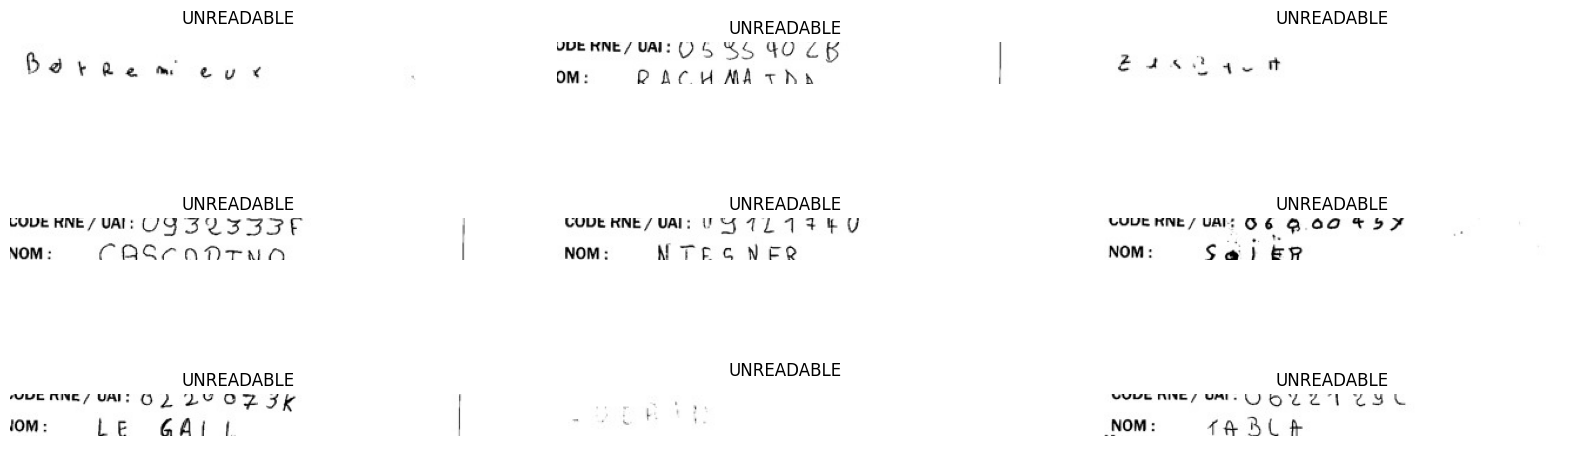

In [10]:
plt.figure(figsize=(20,30))
for i in range(9):
    plt.subplot(3,3,i+1)
    img_loc = img_dir+train_loc+unreadable.loc[i,'FILENAME']
    image = cv2.imread(img_loc,cv2.IMREAD_COLOR)
    plt.imshow(image)
    plt.title(unreadable.loc[i,"IDENTITY"])
    plt.axis('off')

plt.subplots_adjust(wspace=0.2 , hspace=-0.91)

Actually cleaning the UNREADABLE data

In [11]:
train = train[train['IDENTITY'] != 'UNREADABLE' ]
test = test[test['IDENTITY'] != 'UNREADBLE']

In [12]:
train['IDENTITY'] = train['IDENTITY'].str.upper()
test['IDENTITY'] = test['IDENTITY'].str.upper()

In [13]:
train.head()

,FILENAME,IDENTITY
0,TRAIN_00001.jpg,BALTHAZAR
1,TRAIN_00002.jpg,SIMON
2,TRAIN_00003.jpg,BENES
3,TRAIN_00004.jpg,LA LOVE
4,TRAIN_00005.jpg,DAPHNE


In [14]:
# Resetting the index as we are done with cleaning 
train.reset_index(inplace = True, drop=True) 
test.reset_index(inplace=True,drop=True)

In [15]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels


def label_to_num(label):
    label_num = []
    for ch in label:
        label_num.append(alphabets.find(ch))
    return np.array(label_num)

def num_to_label(num):
    ret = ""
    for ch in num:
        if ch == -1:  # CTC Blank
            break
        else:
            ret+=alphabets[ch]
    return ret

In [16]:
type(test)

pandas.core.frame.DataFrame

In [17]:
name ="JOHNSON"
print(label_to_num(name))

[ 9 14  7 13 18 14 13]


In [18]:
def preprocess(img):
    (h, w) = img.shape
    final_img = np.ones([64, 256])*255 # blank white image
    
    # crop
    if w > 256:
        img = img[:, :256]
        
    if h > 64:
        img = img[:64, :]
    
    
    final_img[:h, :w] = img
    return cv2.rotate(final_img, cv2.ROTATE_90_CLOCKWISE)

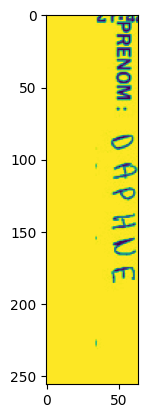

In [19]:
image = cv2.imread(img_dir+train_loc+train.loc[4,'FILENAME'], cv2.IMREAD_GRAYSCALE)
image = preprocess(image)
plt.imshow(image)


In [20]:
train_size = 30000
test_size= 3000

In [21]:
img_train_loc = img_dir

In [22]:
train_x = []

for i in range(train_size):
    img_loc = img_dir+train_loc+train.loc[i, 'FILENAME']
    image = cv2.imread(img_loc, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    train_x.append(image)

In [23]:
test_x = []

for i in range(test_size):
    img_loc = img_dir+test_loc+test.loc[i, 'FILENAME']
    image = cv2.imread(img_loc, cv2.IMREAD_GRAYSCALE)
    image = preprocess(image)
    image = image/255.
    test_x.append(image)

In [24]:
train_x[0].shape

(256, 64)

In [25]:
train_x = np.array(train_x).reshape(-1, 256, 64, 1)
test_x = np.array(test_x).reshape(-1, 256, 64, 1)

In [26]:
train_x.shape

(30000, 256, 64, 1)

Mkaing the output ready 

In [27]:
alphabets = u"ABCDEFGHIJKLMNOPQRSTUVWXYZ-' "
max_str_len = 24 # max length of input labels
num_of_characters = len(alphabets) + 1 # +1 for ctc pseudo blank
num_of_timestamps = 64 # max length of predicted labels

In [28]:
train_y = np.ones([train_size, max_str_len]) 
train_label_len = np.zeros([train_size, 1])
train_input_len = np.ones([train_size, 1]) * (num_of_timestamps-2)
train_output = np.zeros([train_size])

for i in range(train_size):
    train_label_len[i] = len(train.loc[i, 'IDENTITY'])
    train_y[i, 0:len(train.loc[i, 'IDENTITY'])]= label_to_num(train.loc[i, 'IDENTITY'])  

In [29]:
type(train)

pandas.core.frame.DataFrame

In [30]:
test_y = np.ones([test_size, max_str_len]) 
test_label_len = np.zeros([test_size, 1])
test_input_len = np.ones([test_size, 1]) * (num_of_timestamps-2)
test_output = np.zeros([test_size])

for i in range(test_size):
    test_label_len[i] = len(test.loc[i, 'IDENTITY'])
    test_y[i, 0:len(test.loc[i, 'IDENTITY'])]= label_to_num(test.loc[i, 'IDENTITY']) 

In [ ]:
# for i in train_y:
#     print(i)

In [32]:
print('True label : ',train.loc[100, 'IDENTITY'] , '\ntrain_y : ',train_y[100],'\ntrain_label_len : ',train_label_len[100], 
      '\ntrain_input_len : ', train_input_len[100])

True label :  NOUR 
train_y :  [13. 14. 20. 17.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.  1.
  1.  1.  1.  1.  1.  1.] 
train_label_len :  [4.] 
train_input_len :  [62.]


In [33]:
input_data = Input(shape=(256, 64, 1), name='input')

inner = Conv2D(32, (3, 3), padding='same', name='conv1', kernel_initializer='he_normal')(input_data)  
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max1')(inner)

inner = Conv2D(64, (3, 3), padding='same', name='conv2', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(2, 2), name='max2')(inner)
inner = Dropout(0.3)(inner)

inner = Conv2D(128, (3, 3), padding='same', name='conv3', kernel_initializer='he_normal')(inner)
inner = BatchNormalization()(inner)
inner = Activation('relu')(inner)
inner = MaxPooling2D(pool_size=(1, 2), name='max3')(inner)
inner = Dropout(0.3)(inner)

# CNN to RNN
inner = Reshape(target_shape=((64, 1024)), name='reshape')(inner)
inner = Dense(64, activation='relu', kernel_initializer='he_normal', name='dense1')(inner)

## RNN
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm1')(inner)
inner = Bidirectional(LSTM(256, return_sequences=True), name = 'lstm2')(inner)

## OUTPUT
inner = Dense(num_of_characters, kernel_initializer='he_normal',name='dense2')(inner)
y_pred = Activation('softmax', name='softmax')(inner)

model = Model(inputs=input_data, outputs=y_pred)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 256, 64, 1)]      0         
                                                                 
 conv1 (Conv2D)              (None, 256, 64, 32)       320       
                                                                 
 batch_normalization (BatchN  (None, 256, 64, 32)      128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 256, 64, 32)       0         
                                                                 
 max1 (MaxPooling2D)         (None, 128, 32, 32)       0         
                                                                 
 conv2 (Conv2D)              (None, 128, 32, 64)       18496     
                                                             

In [34]:
# the ctc loss function
def ctc_lambda_func(args):
    y_pred, labels, input_length, label_length = args
    # the 2 is critical here since the first couple outputs of the RNN
    # tend to be garbage
    y_pred = y_pred[:, 2:, :]
    return K.ctc_batch_cost(labels, y_pred, input_length, label_length)

In [35]:
labels = Input(name='gtruth_labels', shape=[max_str_len], dtype='float32')
input_length = Input(name='input_length', shape=[1], dtype='int64')
label_length = Input(name='label_length', shape=[1], dtype='int64')

ctc_loss = Lambda(ctc_lambda_func, output_shape=(1,), name='ctc')([y_pred, labels, input_length, label_length])
model_final = Model(inputs=[input_data, labels, input_length, label_length], outputs=ctc_loss)

In [36]:
# the loss calculation occurs elsewhere, so we use a dummy lambda function for the loss
model_final.compile(loss={'ctc': lambda y_true, y_pred: y_pred}, optimizer=Adam(lr = 0.0001))

model_final.fit(x=[train_x, train_y, train_input_len, train_label_len], y=train_output, 
                validation_data=([test_x, test_y, test_input_len, test_label_len], test_output),
                epochs=60, batch_size=20)

c:\Users\johns\anaconda3\envs\machine-learning-conda\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Epoch 1/60
1500/1500 [==============================] - 79s 48ms/step - loss: 20.6632 - val_loss: 18.9348
Epoch 2/60
1500/1500 [==============================] - 72s 48ms/step - loss: 15.6355 - val_loss: 10.9005
Epoch 3/60
1500/1500 [==============================] - 70s 46ms/step - loss: 7.8400 - val_loss: 5.3196
Epoch 4/60
1500/1500 [==============================] - 71s 47ms/step - loss: 5.0034 - val_loss: 3.7627
Epoch 5/60
1500/1500 [==============================] - 71s 47ms/step - loss: 3.9032 - val_loss: 3.0891
Epoch 6/60
1500/1500 [==============================] - 69s 46ms/step - loss: 3.3096 - val_loss: 2.7378
Epoch 7/60
1500/1500 [==============================] - 70s 46ms/step - loss: 2.9348 - val_loss: 2.4656
Epoch 8/60
1500/1500 [==============================] - 71s 47ms/step - loss: 2.6353 - val_loss: 2.3266
Epoch 9/60
1500/1500 [==============================] - 69s 46ms/step - loss: 2.4394 - val_loss: 2.1386
Epoch 10/60
1500/1500 [==============================] - 71s

In [37]:
preds = model.predict(test_x)
decoded = K.get_value(K.ctc_decode(preds, input_length=np.ones(preds.shape[0])*preds.shape[1], 
                                   greedy=True)[0][0])

prediction = []
for i in range(test_size):
    prediction.append(num_to_label(decoded[i]))

94/94 [==============================] - 3s 21ms/step


In [41]:
model_final.save("HWR_model.keras")

In [ ]:
y_true = test.loc[0:test_size, 'IDENTITY']
correct_char = 0
total_char = 0
correct = 0

for i in range(test_size):
    pr = prediction[i]
    tr = y_true[i]
    print(tr)
    print(type(tr))
    if(type(tr)== float):
        total_char+=1
    
        total_char += len(tr)
    
    for j in range(min(len(tr), len(pr))):
        if tr[j] == pr[j]:
            correct_char += 1
            
    if pr == tr :
        correct += 1 
    
print('Correct characters predicted : %.2f%%' %(correct_char*100/total_char))
print('Correct words predicted      : %.2f%%' %(correct*100/test_size))

1/1 [==============================] - 0s 89ms/step
[2.53818455e-09 1.05837071e-05 1.97337719e-08 2.18161495e-06
 2.33650781e-06 6.69871906e-06 1.43005047e-06 3.06926722e-06
 1.28891307e-08 2.23830455e-07 9.97966945e-01 1.89559250e-05
 9.21450791e-08 1.92796369e-06 1.65690706e-09 2.45882675e-05
 2.50572100e-07 1.44988636e-03 4.72579359e-06 1.04313933e-07
 3.17723958e-09 8.83656412e-07 1.09798385e-07 5.01365575e-04
 3.56399619e-06 4.67609107e-09 1.19581720e-10 3.09148018e-09
 4.22640873e-08 3.63038696e-11]
1/1 [==============================] - 0s 91ms/step
[4.4279039e-07 1.3251257e-05 8.9398974e-01 1.8855400e-07 1.0153197e-01
 8.4245554e-04 3.5397417e-04 6.9663929e-06 1.4938057e-05 1.6193187e-06
 8.0163468e-04 1.1040214e-03 3.2070081e-04 4.1560546e-05 1.0012200e-06
 7.8955200e-05 9.3647498e-07 2.0189247e-05 1.4049001e-06 1.5409478e-05
 7.4336222e-06 2.8399879e-04 4.1658702e-04 1.1488933e-04 1.0929437e-05
 4.2513084e-06 9.3066346e-06 1.0106958e-07 1.1143481e-05 1.1706819e-08]
1/1 [=====

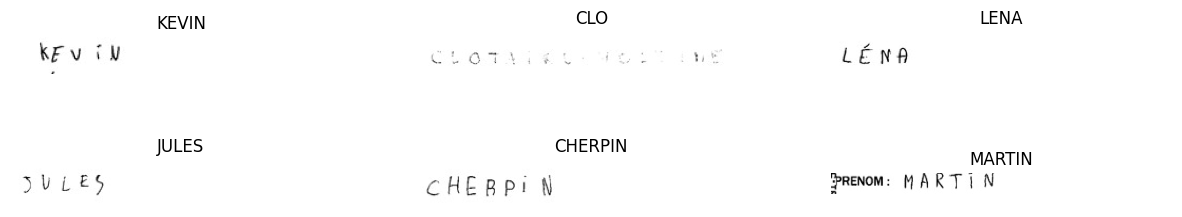

In [75]:
test = pd.read_csv('../dataset/written_name_test_v2.csv')
plt.figure(figsize=(15, 10))
for i in range(6):
    ax = plt.subplot(2, 3, i+1)
    img_loc = "../dataset/test_v2/test/"+test.loc[i, 'FILENAME']
    image = cv2.imread(img_loc, cv2.IMREAD_GRAYSCALE)
    plt.imshow(image, cmap='gray')
    image = preprocess(image)
    image = image/255.
    pred = model.predict(image.reshape(1, 256, 64, 1))
    print(pred[0][1])
    decoded = K.get_value(K.ctc_decode(pred, input_length=np.ones(pred.shape[0])*pred.shape[1], 
                                       greedy=True)[0][0])
    plt.title(num_to_label(decoded[0]), fontsize=12)
    plt.axis('off')
    
plt.subplots_adjust(wspace=0.2, hspace=-0.8)